In [2]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
import pandas as pd
from PIL import Image

import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader

import albumentations as A
from albumentations.pytorch import ToTensorV2

import cv2

from tqdm import tqdm

import matplotlib.pyplot as plt
%matplotlib inline

2025-05-21 14:11:03.313933: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747829463.327333 3754746 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747829463.331460 3754746 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747829463.343318 3754746 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747829463.343329 3754746 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747829463.343331 3754746 computation_placer.cc:177] computation placer alr

In [6]:
img = Image.open('data/train/00000001_001.png')
print(img.mode)  # 'L' = grayscale

L


In [3]:
img = load_img('data/train/00000001_001.png')  # this is a PIL image
x = img_to_array(img)  # this is a Numpy array
print (f'Orignal size: {x.shape}') # PIL converts to RGB (3)

Orignal size: (1024, 1024, 3)


In [10]:
df = pd.read_csv('./data/Data_Entry_2017_v2020.csv') 
df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Sex,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168


In [11]:
df.isna().any()

Image Index                    False
Finding Labels                 False
Follow-up #                    False
Patient ID                     False
Patient Age                    False
Patient Sex                    False
View Position                  False
OriginalImage[Width            False
Height]                        False
OriginalImagePixelSpacing[x    False
y]                             False
dtype: bool

In [12]:
num_unique_patients = df['Patient ID'].nunique()
print(f"Unique Patients: {num_unique_patients}")


Unique Patients: 30805


In [14]:
images_per_patient = df['Patient ID'].value_counts()
print("Images per patient (Top 10):")
print(images_per_patient.head(10))

# Optioneel: gemiddelde en max
print(f" Average images per patient: {images_per_patient.mean():.2f}")


Images per patient (Top 10):
Patient ID
10007    184
13670    173
15530    158
12834    157
13993    143
1836     137
19124    130
20213    119
17138    117
11237    116
Name: count, dtype: int64
 Average images per patient: 3.64


In [15]:
# Pathologie
all_labels = df['Finding Labels'].str.split('|').explode()

unique_labels = all_labels.unique()
num_labels = len(unique_labels)

print(f"Unique patholgies (labels): {num_labels}")
print(f"Unique labels: {unique_labels}")


Unique patholgies (labels): 15
Unique labels: ['Cardiomegaly' 'Emphysema' 'Effusion' 'No Finding' 'Hernia'
 'Infiltration' 'Mass' 'Nodule' 'Atelectasis' 'Pneumothorax'
 'Pleural_Thickening' 'Pneumonia' 'Fibrosis' 'Edema' 'Consolidation']


In [22]:
# Unique label combinations (mulit labels)
unique_combinations = df['Finding Labels'].nunique()
print(f"Amount of unique label combinations: {unique_combinations}")

# Most common multi labels
print("Top 10 most common combinations:")
print(df['Finding Labels'].value_counts().head(10))

# Least common multi labels
print("Top 10 least common combinations:")
print(df['Finding Labels'].value_counts().tail(10))



Amount of unique label combinations: 836
Top 10 most common combinations:
Finding Labels
No Finding                  60361
Infiltration                 9547
Atelectasis                  4215
Effusion                     3955
Nodule                       2705
Pneumothorax                 2194
Mass                         2139
Effusion|Infiltration        1603
Atelectasis|Infiltration     1350
Consolidation                1310
Name: count, dtype: int64
Top 10 least common combinations:
Finding Labels
Emphysema|Infiltration|Pleural_Thickening|Pneumonia                  1
Effusion|Fibrosis|Mass|Pleural_Thickening                            1
Consolidation|Effusion|Mass|Nodule|Pleural_Thickening|Atelectasis    1
Effusion|Mass|Pneumonia|Pneumothorax                                 1
Atelectasis|Consolidation|Edema|Effusion|Pleural_Thickening          1
Atelectasis|Consolidation|Edema|Effusion|Infiltration|Pneumonia      1
Atelectasis|Consolidation|Effusion|Emphysema|Mass|Pneumothorax       1

# Label Distribution

In [11]:
df = pd.read_csv('./data/train_labels_encoded.csv') 

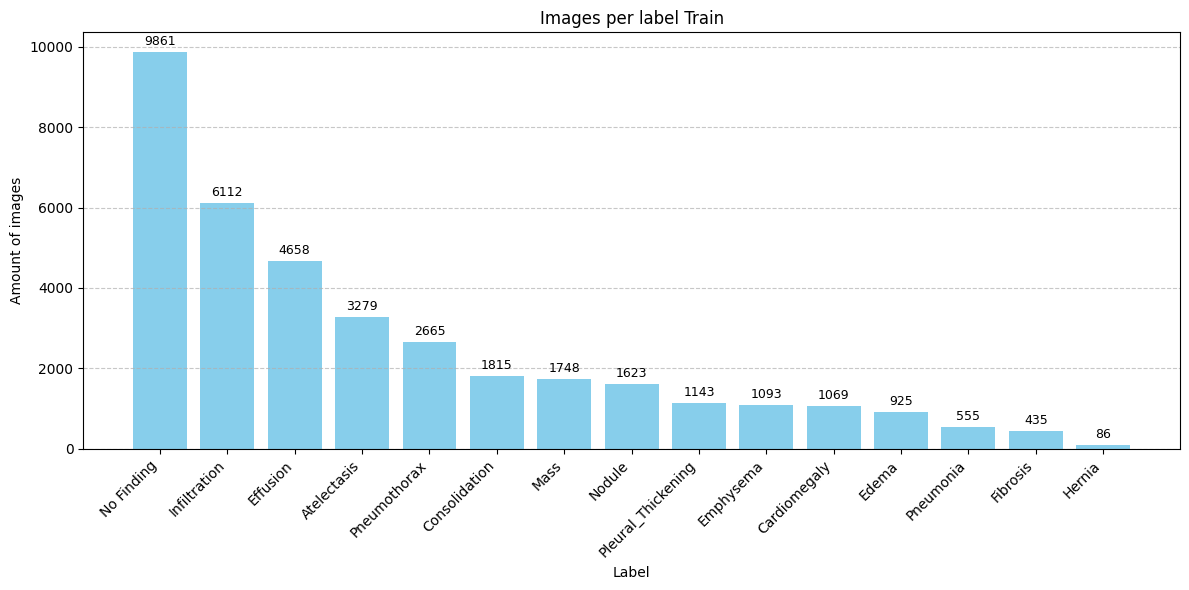

In [5]:
import matplotlib.pyplot as plt

# Tel het aantal keren dat elk label voorkomt
label_counts = df.iloc[:, 1:].sum().sort_values(ascending=False)

# Plot de aantallen per label
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts.values, color='skyblue')

# Voeg waarden boven de bars toe
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100,  # beetje ruimte erboven
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.title('Images per label Train')
plt.ylabel('Amount of images')
plt.xlabel('Label')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


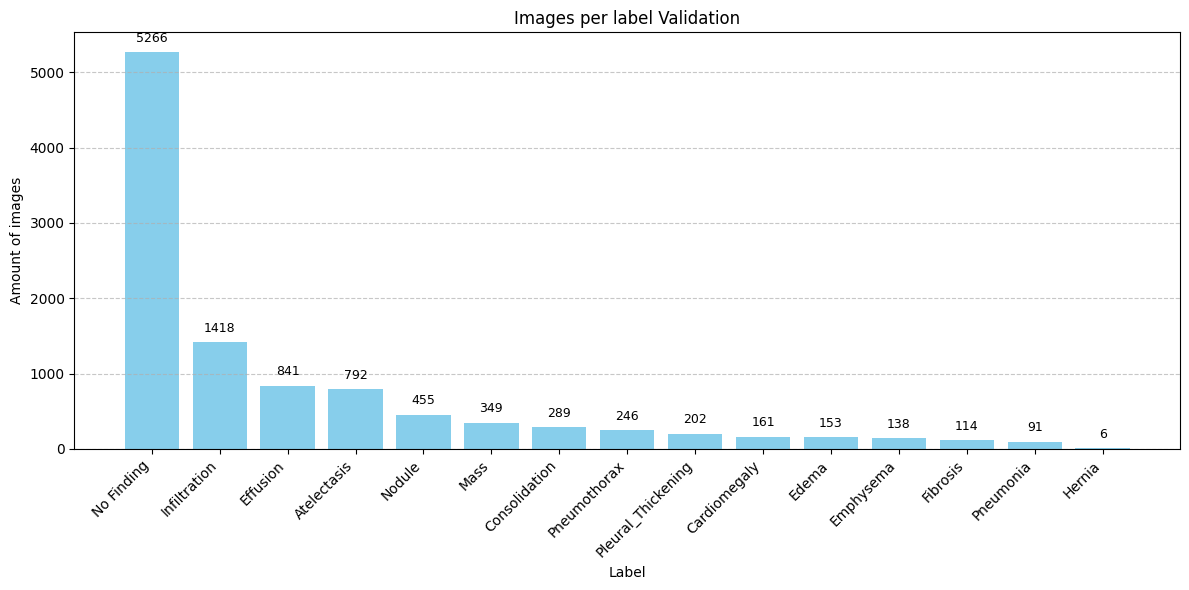

In [6]:
df = pd.read_csv('./data/val_labels_encoded.csv') 
import matplotlib.pyplot as plt

# Tel het aantal keren dat elk label voorkomt
label_counts = df.iloc[:, 1:].sum().sort_values(ascending=False)

# Plot de aantallen per label
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts.values, color='skyblue')

# Voeg waarden boven de bars toe
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100,  # beetje ruimte erboven
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.title('Images per label Validation')
plt.ylabel('Amount of images')
plt.xlabel('Label')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


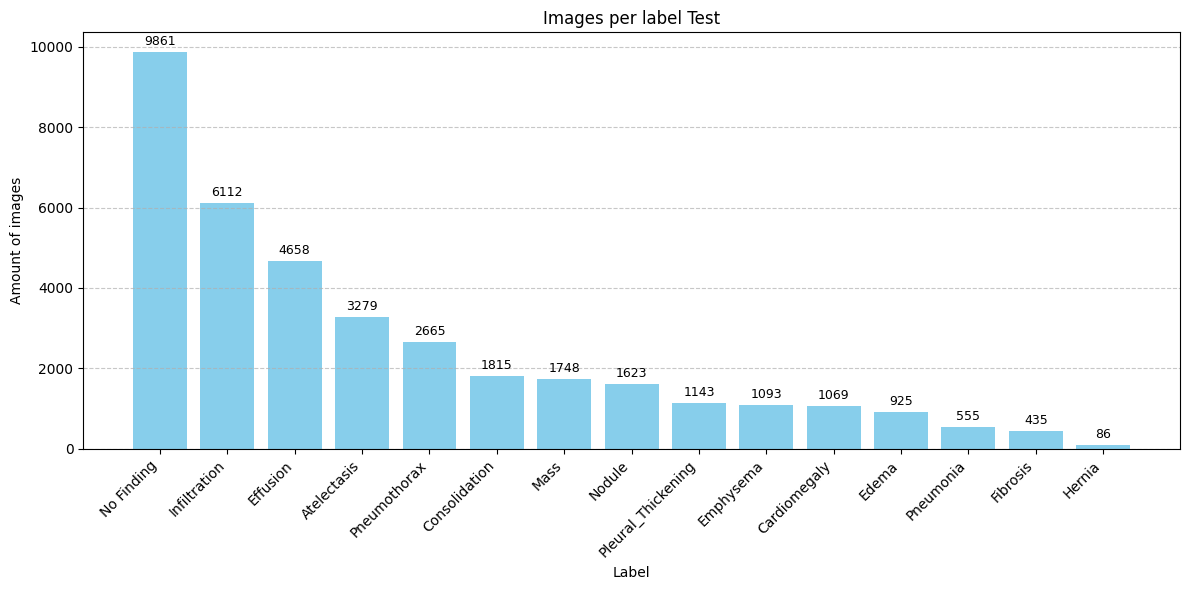

In [7]:
df = pd.read_csv('./data/test_labels_encoded.csv') 
import matplotlib.pyplot as plt

# Tel het aantal keren dat elk label voorkomt
label_counts = df.iloc[:, 1:].sum().sort_values(ascending=False)

# Plot de aantallen per label
plt.figure(figsize=(12, 6))
bars = plt.bar(label_counts.index, label_counts.values, color='skyblue')

# Voeg waarden boven de bars toe
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 100,  # beetje ruimte erboven
             f'{int(height)}', ha='center', va='bottom', fontsize=9)

plt.title('Images per label Test')
plt.ylabel('Amount of images')
plt.xlabel('Label')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
